In [222]:
import pandas as pd
import numpy as np
import string
import sys
import re

#text processing, NLP modules
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.cluster import KMeansClusterer
 
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.cluster import DBSCAN, MiniBatchKMeans, KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import gensim.downloader
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15, 10)

In [223]:
#!pip install python-Levenshtein

In [224]:
stopwords = nltk.corpus.stopwords.words('english')

In [809]:
df_tweety = pd.read_csv("Data/vaccination_tweets.csv")

In [810]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [811]:
def clean_tweet_vader(x):
    ''' Pre process and convert texts to a list of words 
    method inspired by method from eliorc github repo: https://github.com/eliorc/Medium/blob/master/MaLSTM.ipynb'''
    x = str(x)
    x = x.lower()

    #remove twitter handlers
    x = re.sub('@[^\s]+','',x)
    #remove hashtags
    x = re.sub('#[^\s]+','',x)
    #remove URLs
    x = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', x)
    #remove punctuation
    x = x.replace('[^\w\s]','')
    #remove single characters
    x = re.sub(r'\s+[a-zA-Z0-9]\s+', '', x)
    #substitute multiple spaces with single space
    x = re.sub(r'\s+', ' ', x, flags=re.I)
    #remove linebreaks
    x = re.sub('\n', '', x)
    #remove special characters
    x = ' '.join(re.findall(r'\w+', x))
    #substitute multiple spaces with single space
    x = re.sub(r'\s+', ' ', x, flags=re.I)
    #stemming
    x = ' '.join([stemmer.stem(word) for word in x.split() ])
    #lemmatizing
    x = ' '.join([lemmatizer.lemmatize(word) for word in x.split() ])
    #removing stop words
    x = ' '.join([word for word in x.split() if word not in stopwords])
    #x = x.split()

    return x

In [836]:
df_tweety.text = df_tweety.text.apply(lambda x: tweet_to_word_list(x))

In [837]:
df_tweety.text.iloc[64]

'say shipment vaccin continu ship missouri 21 vaccinat'

In [838]:
sentences = [row for row in df_tweety.text]

In [840]:
# Downloading the GLoVe Pretrained Vectorizer
#glove_vectors = gensim.downloader.load('glove-wiki-gigaword-50')

In [841]:
# Creating a function that calculates the embeddings for the whole sentence by summing up the embedding of 
# each word und dividing it by the sum of words in the sentence
def sent_vectorizer(sent, model):
    sent_vec =[]
    numw = 0
    values = sent.split()
    for w in values:
        try:
            if numw == 0:
                sent_vec = model[w]
            else:
                sent_vec = np.add(sent_vec, model[w])
            numw+=1
        except:
            pass
    
    return np.asarray(sent_vec) / numw
  
# Saving the embeddings in a list X
X=[]
for sentence in sentences:
    X.append(sent_vectorizer(sentence, glove_vectors))   

In [842]:
#X[62]

X_new = [arr for arr in X if arr!=[]]

<ipython-input-842-66b1d707c5dd>:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  X_new = [arr for arr in X if arr!=[]]
<ipython-input-842-66b1d707c5dd>:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  X_new = [arr for arr in X if arr!=[]]


In [843]:
#arr = np.stack(arr, axis=0)
#arr.shape
#arr = np.asarray(X)
#arr.ndim
#arr = np.reshape(arr, (-1, 1))

In [845]:
X_new[62]

array([-0.02984   ,  0.13757   ,  0.7024325 ,  0.664925  , -0.024334  ,
       -0.02181999, -0.17141101, -0.5480525 , -0.14820251, -0.04413545,
       -0.28735474,  0.18020001, -0.65259004, -0.07911751, -0.18285249,
        0.173625  , -0.10721826, -0.03547475, -0.0439655 , -0.417315  ,
        0.3776375 , -0.2895225 , -0.09165026,  0.1257875 , -0.431735  ,
       -0.59548503,  0.261445  , -0.146655  ,  0.13356799, -0.01023   ,
        2.497575  ,  0.16177401,  0.06157875,  0.27646425, -0.024826  ,
       -0.21928799,  0.1050975 , -0.5461875 ,  0.48090002, -0.02882   ,
        0.30339748, -0.12634951, -0.243087  ,  0.0342075 ,  0.21203162,
        0.65111   ,  0.03898749,  0.05332001,  0.176716  ,  0.33543003],
      dtype=float32)

In [794]:
#arr

In [846]:
# Using PCA for Dimensionality Reduction
# And the StandardScaler to scale the data 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_new)
pca_ = PCA(0.99, random_state=0)
X_pca=pca_.fit_transform(X_scaled)

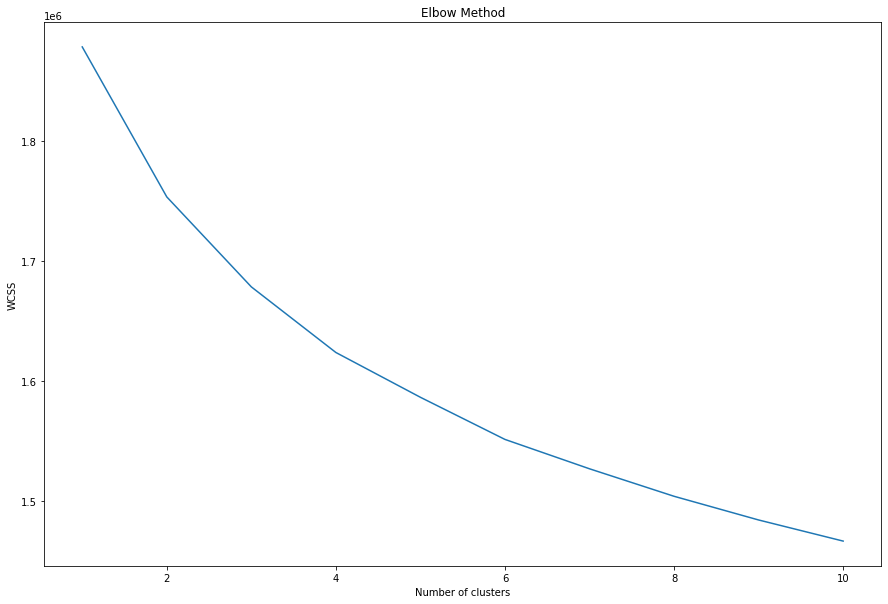

In [847]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=150, n_init=10, random_state=0)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [848]:
# Creating the MiniBatchKMeans Clustering model and fit it to our preprocessed data
batch_kmeans = MiniBatchKMeans(n_clusters=3, verbose=0, max_iter=150, n_init=50, random_state=0)
batch_kmeans.fit(X_pca)

MiniBatchKMeans(max_iter=150, n_clusters=3, n_init=50, random_state=0)

/Users/christophmichel/.pyenv/versions/3.8.5/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


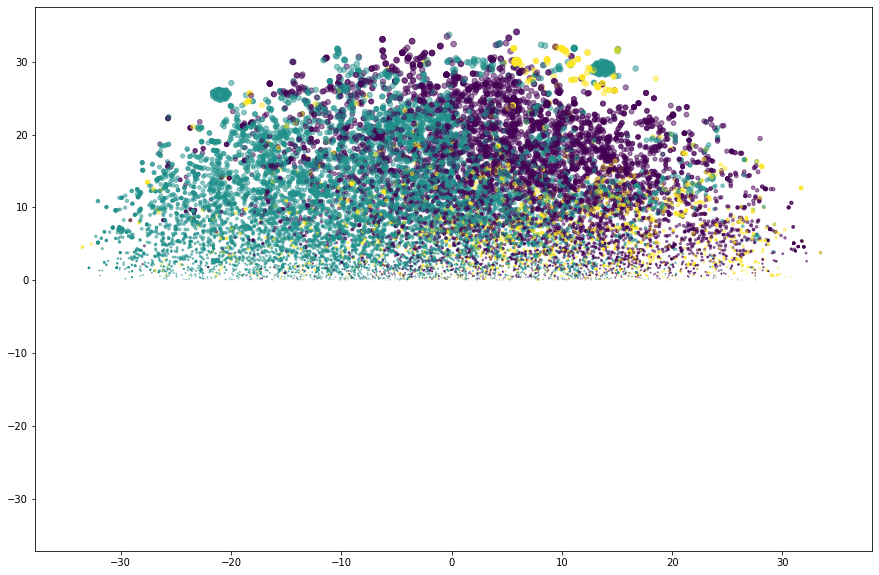

In [849]:
# Using t-SNE to prepare the data for plotting
model1 = TSNE(n_components=3, random_state=0)

Y = model1.fit_transform(X_pca)

plt.scatter(Y[:, 0], Y[:, 1], Y[:, 1], c=batch_kmeans.labels_, alpha=.5)#s=190, alpha=.5);
#for j in range(len(sentences)):    
    #plt.annotate(data.target[j], xy=(Y[j][0], Y[j][1]), xytext=(0,0), textcoords='offset points') 

In [850]:
Y

array([[ -9.325998 , -12.832308 ,   5.239188 ],
       [ -2.0689218,  15.703397 ,  -3.3468585],
       [ -5.483824 , -21.366827 , -27.509129 ],
       ...,
       [ -7.8090878,  -5.5800223, -29.798044 ],
       [ -9.678195 , -12.563124 , -10.067431 ],
       [ 16.077608 , -22.600311 ,  -9.363249 ]], dtype=float32)

In [863]:
model.clusters_centers_

AttributeError: 'Word2Vec' object has no attribute 'clusters_centers_'

In [853]:
# Importing the word2vec model
model = Word2Vec(sentences, min_count=1)


# Creating the KMeans Clustering model with the implementation of the nltk library
NUM_CLUSTERS=3
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X_pca, assign_clusters=True)

/Users/christophmichel/.pyenv/versions/3.8.5/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


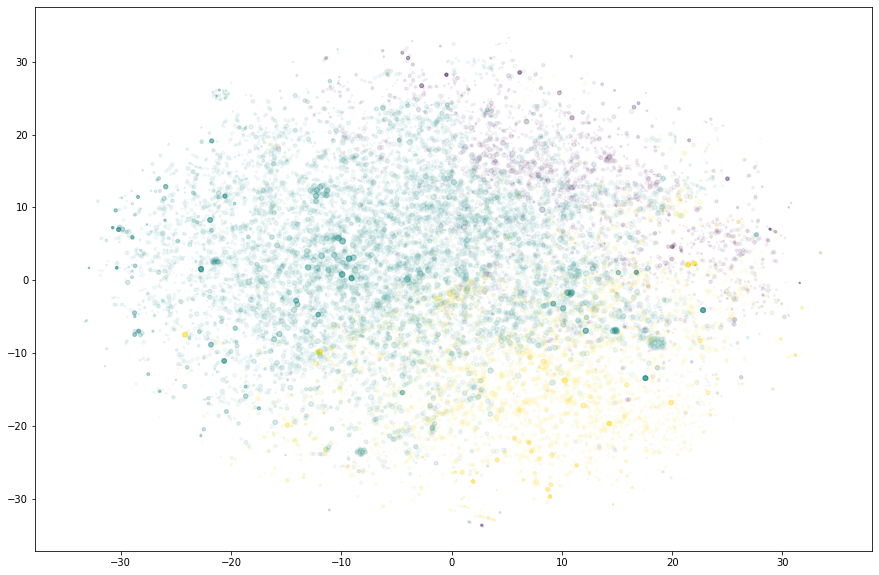

In [858]:
# Using t-SNE to prepare the data for plotting
model1 = TSNE(n_components=3, random_state=0)

Y = model1.fit_transform(X_pca)

plt.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=batch_kmeans.labels_, alpha=.05)
#for j in range(len(sentences)):    
    #plt.annotate(data.target[j], xy=(Y[j][0], Y[j][1]), xytext=(0,0), textcoords='offset points') 

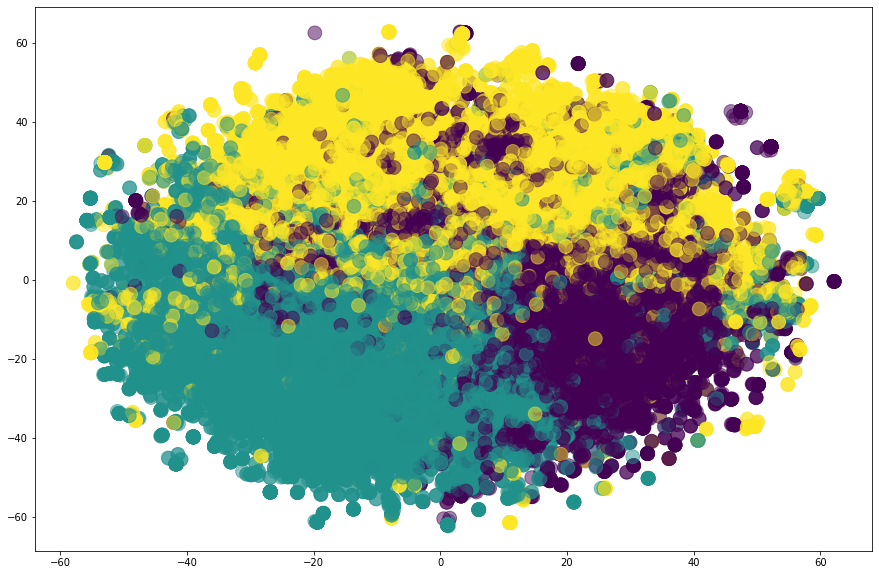

In [861]:
NUM_CLUSTERS=2
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X_pca, assign_clusters=True)

# Using t-SNE to prepare the data for plotting
model1 = TSNE(n_components=2, random_state=0)

Y = model1.fit_transform(X_pca)

plt.scatter(Y[:, 0], Y[:, 1], c=batch_kmeans.labels_, s=190, alpha=.5)